In [1]:
import tensorflow as tf
import numpy as np
import math
import os
import random
import numpy as np
import pandas as pd
from pandas import DataFrame
import pickle
import math
import copy

In [3]:
state_features = ['MIMICzs1','MIMICzs2','MIMICzs3','MIMICzs4','MIMICzs5','MIMICzs6','MIMICzs7','MIMICzs8','MIMICzs9','MIMICzs10','MIMICzs11','MIMICzs12','MIMICzs13','MIMICzs14','MIMICzs15','MIMICzs16','MIMICzs17','MIMICzs18','MIMICzs19','MIMICzs20','MIMICzs21','MIMICzs22','MIMICzs23','MIMICzs24','MIMICzs25','MIMICzs26','MIMICzs27','MIMICzs28','MIMICzs29','MIMICzs30','MIMICzs31','MIMICzs32','MIMICzs33','MIMICzs34','MIMICzs35','MIMICzs36','MIMICzs37','MIMICzs38','MIMICzs39','MIMICzs40','MIMICzs41','MIMICzs42','MIMICzs43','MIMICzs44','MIMICzs45','MIMICzs46','MIMICzs47', 'abchange_vc']

In [4]:
len(state_features)

47

In [5]:
df = pd.read_csv('data_vasochange/train_withterm.csv')

In [6]:
df.head()

,bloc,icustayid,mortality_90d,MIMICzs1,MIMICzs2,MIMICzs3,MIMICzs4,MIMICzs5,MIMICzs6,MIMICzs7,...,MIMICzs44,MIMICzs45,MIMICzs46,MIMICzs47,action,shaped_reward,io_ac,vc_ac,abchange_vc,max_dose_vaso
0,1,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.187300,0.705956,...,0.391651,0.52761,0.786192,0.702781,10,-1.224270,2,0,0.0,0.0
1,2,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.187300,0.705956,...,0.394176,0.52761,0.793676,0.596530,10,1.640796,2,0,0.0,0.0
2,3,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.187300,0.705956,...,0.396682,0.52761,0.799286,0.516950,10,-0.025000,2,0,0.0,0.0
3,4,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.155313,0.705956,...,0.399169,0.52761,0.805952,0.575231,10,-0.025000,2,0,0.0,0.0
4,5,3,1,-0.5,-0.5,-0.5,-2.302585,-0.978344,-0.147317,0.705956,...,0.401637,0.52761,0.816227,0.714111,10,-0.025000,2,0,0.0,0.0


In [7]:
val_df = pd.read_csv('data_vasochange/val_withterm.csv') 

In [8]:
test_df = pd.read_csv('data_vasochange/test_withterm.csv')

In [9]:
# define an action mapping - how to get an id representing the action from the (iv,vaso) tuple
action_map = {}
count = 0
for iv in range(5):
    for vaso in range(5):
        action_map[(iv,vaso)] = count
        count += 1

In [10]:
print(action_map)

{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (0, 4): 4, (1, 0): 5, (1, 1): 6, (1, 2): 7, (1, 3): 8, (1, 4): 9, (2, 0): 10, (2, 1): 11, (2, 2): 12, (2, 3): 13, (2, 4): 14, (3, 0): 15, (3, 1): 16, (3, 2): 17, (3, 3): 18, (3, 4): 19, (4, 0): 20, (4, 1): 21, (4, 2): 22, (4, 3): 23, (4, 4): 24}


In [11]:
inv_action_map = {}
for iv in range(5):
    for vaso in range(5):
        inv_action_map[5*iv+vaso] = [iv,vaso]

In [12]:
print(inv_action_map)

{0: [0, 0], 1: [0, 1], 2: [0, 2], 3: [0, 3], 4: [0, 4], 5: [1, 0], 6: [1, 1], 7: [1, 2], 8: [1, 3], 9: [1, 4], 10: [2, 0], 11: [2, 1], 12: [2, 2], 13: [2, 3], 14: [2, 4], 15: [3, 0], 16: [3, 1], 17: [3, 2], 18: [3, 3], 19: [3, 4], 20: [4, 0], 21: [4, 1], 22: [4, 2], 23: [4, 3], 24: [4, 4]}


In [24]:
# load in the actions from the q network
q_net_save_dir = 'vasochange4_dqn_normal/'
train_actions = pickle.load(open( q_net_save_dir + "dqn_normal_actions_train.p", "rb" ))
val_actions = pickle.load(open( q_net_save_dir + "dqn_normal_actions_val.p", "rb" ))
test_actions = pickle.load(open( q_net_save_dir + "dqn_normal_actions_test.p", "rb" ))

df['agent_actions'] = train_actions
df['agent_iv'] = df['agent_actions'].apply(lambda x:inv_action_map[x][0] )
df['agent_vaso'] = df['agent_actions'].apply(lambda x:inv_action_map[x][1] )

val_df['agent_actions'] = val_actions
val_df['agent_iv'] = val_df['agent_actions'].apply(lambda x:inv_action_map[x][0] )
val_df['agent_vaso'] = val_df['agent_actions'].apply(lambda x:inv_action_map[x][1] )

test_df['agent_actions'] = test_actions
test_df['agent_iv'] = test_df['agent_actions'].apply(lambda x:inv_action_map[x][0] )
test_df['agent_vaso'] = test_df['agent_actions'].apply(lambda x:inv_action_map[x][1] )


In [25]:
# preprocess the actions so that they are zero mean
df['iv_input'] = df['io_ac'].apply(lambda x: x/4.0)
df['vaso_input'] = df['vc_ac'].apply(lambda x: x/4.0)

val_df['iv_input'] = val_df['io_ac'].apply(lambda x: x/4.0)
val_df['vaso_input'] = val_df['vc_ac'].apply(lambda x: x/4.0)

test_df['iv_input'] = test_df['io_ac'].apply(lambda x: x/4.0)
test_df['vaso_input'] = test_df['vc_ac'].apply(lambda x: x/4.0)

df['agent_iv'] = df['agent_iv'].apply(lambda x: x/4.0)
df['agent_vaso'] = df['agent_vaso'].apply(lambda x: x/4.0)

val_df['agent_iv'] = val_df['agent_iv'].apply(lambda x: x/4.0)
val_df['agent_vaso'] = val_df['agent_vaso'].apply(lambda x: x/4.0)

test_df['agent_iv'] = test_df['agent_iv'].apply(lambda x: x/4.0)
test_df['agent_vaso'] = test_df['agent_vaso'].apply(lambda x: x/4.0)


In [26]:
# Add Gaussian noise to the state features
gaussian_shape = df.loc[:, state_features].values.shape
noise = np.random.normal(0, 0.03, gaussian_shape)
df.loc[:, state_features] += noise

In [27]:
hidden_1_size = 500
hidden_2_size = 500
class EnvModel():
    def __init__(self):
        self.phase = tf.placeholder(tf.bool)
        
        self.input_size = len(state_features)

        self.cur_state = tf.placeholder(tf.float32, shape=[None, self.input_size],name="cur_state")
        self.next_state = tf.placeholder(tf.float32, shape=[None, self.input_size],name="next_state")
        
        self.done_flags = tf.placeholder(tf.int32, shape=[None], name="done_flags")
        
        self.actions = tf.placeholder(tf.int32, shape = [None, 2], name="actions")
        
        self.input = tf.concat([self.cur_state, tf.cast(self.actions, tf.float32)], axis=1)
        
        self.target = self.next_state - self.cur_state

        self.fc_1 = tf.contrib.layers.fully_connected(self.input, hidden_1_size, activation_fn=tf.nn.relu)
        self.fc_1_bn = tf.contrib.layers.batch_norm(self.fc_1, center=True, scale=True, is_training=self.phase)
        self.fc_2 = tf.contrib.layers.fully_connected(self.fc_1_bn, hidden_2_size, activation_fn=tf.nn.relu)
        self.fc_2_bn = tf.contrib.layers.batch_norm(self.fc_2, center=True, scale=True, is_training=self.phase)
        
        self.output = tf.contrib.layers.fully_connected(self.fc_2_bn, self.input_size, activation_fn = None)
        
        self.multiplier = tf.expand_dims(1 -self.done_flags, 1)
        
        self.loss = tf.reduce_mean(tf.multiply(tf.square(self.target-self.output), tf.cast(self.multiplier, tf.float32)))  
        
        self.est_next_state = self.output + self.cur_state

        self.trainer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(self.update_ops):
        # Ensures that we execute the update_ops before performing the model update, so batchnorm works
            self.update_model = self.trainer.minimize(self.loss)

In [28]:
def process_train_batch(size):
    a = df.sample(n=size)
    states = None
    actions = None
    rewards = None
    next_states = None
    done_flags = None
    for i in a.index:
        cur_state = a.ix[i,state_features]
        #print(a.ix[i, 'iv_input'])
        iv = int(a.ix[i, 'iv_input'])
        vaso = int(a.ix[i, 'vaso_input'])
        action = np.array([iv,vaso])

        
        if i != df.index[-1]:
            # if not terminal step in trajectory             
            if df.ix[i, 'icustayid'] == df.ix[i+1, 'icustayid']:
                next_state = df.ix[i + 1, state_features]
                done = 0
            else:
                # trajectory is finished
               # print(df.ix[i, 'icustayid'], df.ix[i+1,'icustayid'])
                next_state = np.zeros(len(cur_state))
                done = 1
        else:
            # last entry in df is the final state of that trajectory
            #print("why")
            next_state = np.zeros(len(cur_state))
            done = 1

        if states is None:
            states = copy.deepcopy(cur_state)
        else:
            states = np.vstack((states,cur_state))

        if actions is None:
            actions = [action]
        else:
            actions = np.vstack((actions,action))

        if next_states is None:
            next_states = copy.deepcopy(next_state)
        else:
            next_states = np.vstack((next_states,next_state))

        if done_flags is None:
            done_flags = [done]
        else:
            done_flags = np.vstack((done_flags,done))
    
    return (states, np.squeeze(actions), next_states, np.squeeze(done_flags), a)

In [29]:
# extract chunks of length size from the relevant dataframe, and yield these to the caller
# final tells us if we want to use AGENT actions, not physician actions
def process_eval_batch(size, eval_type = None, final=False):
    if eval_type is None:
        raise Exception('Provide eval_type to process_eval_batch')
    elif eval_type == 'train':
        a = df.copy()
    elif eval_type == 'val':
        a = val_df.copy()
    elif eval_type == 'test':
        a = test_df.copy()
    else:
        raise Exception('Unknown eval_type')
    count = 0
    while count < len(a.index):
        states = None
        actions = None
        rewards = None
        next_states = None
        done_flags = None

        start_idx = count
        end_idx = min(len(a.index), count+size)
        segment = a.index[start_idx:end_idx]
        
        for i in segment:
            cur_state = a.ix[i,state_features]
            
            if not final:
                iv = int(a.ix[i, 'iv_input'])
                vaso = int(a.ix[i, 'vaso_input'])
                action = np.array([iv,vaso])
            else:
                iv = int(a.ix[i, 'agent_iv'])
                vaso = int(a.ix[i, 'agent_vaso'])
                action = np.array([iv,vaso])
            reward = a.ix[i,'shaped_reward']

            if i != a.index[-1]:
                # if not terminal step in trajectory             
                if a.ix[i, 'icustayid'] == a.ix[i+1, 'icustayid']:
                    next_state = a.ix[i + 1, state_features]
                    done = 0
                else:
                    # trajectory is finished
                    next_state = np.zeros(len(cur_state))
                    done = 1
            else:
                # last entry in df is the final state of that trajectory
                next_state = np.zeros(len(cur_state))
                done = 1

            if states is None:
                states = copy.deepcopy(cur_state)
            else:
                states = np.vstack((states,cur_state))

            if actions is None:
                actions = [action]
            else:
                actions = np.vstack((actions,action))

            if next_states is None:
                next_states = copy.deepcopy(next_state)
            else:
                next_states = np.vstack((next_states,next_state))

            if done_flags is None:
                done_flags = [done]
            else:
                done_flags = np.vstack((done_flags,done))

        yield (states, np.squeeze(actions), next_states, np.squeeze(done_flags), a)
        
        count += size

In [30]:
def do_eval(eval_type, final=False):
    gen = process_eval_batch(size = 1000, eval_type=eval_type, final=final)

    error_ret = 0
    est_next_states = []

    for b in gen:

        states,actions,next_states, done_flags, _ = b

        est_next_state,loss = sess.run([env_model.est_next_state,env_model.loss], \
            feed_dict={env_model.cur_state:states,
                       env_model.next_state:next_states, 
                       env_model.actions:actions,
                       env_model.done_flags:done_flags,
                       env_model.phase:False})    
        error_ret += loss
        est_next_states.append(est_next_state)
        #print(len(est_next_state))
    print(error_ret)
    return np.array(est_next_states), error_ret

In [31]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # Don't use all GPUs 
config.allow_soft_placement = True  # Enable manual control

In [32]:
def do_save_results():
    # get the estimated next states UNDER THE AGENT POLICY based on the trained environment model
    est_next_states_train, _ = do_eval(eval_type = 'train', final=True)        
    est_next_states_val, _ = do_eval(eval_type = 'val', final=True)        
    est_next_states_test, _ = do_eval(eval_type = 'test', final=True)   
    
    # save everything for later - they're used in policy evaluation and when generating plots
    with open(save_dir + 'est_next_states_train.p', 'wb') as f:
        pickle.dump(est_next_states_train, f)
    with open(save_dir + 'est_next_states_val.p', 'wb') as f:
        pickle.dump(est_next_states_val, f)
    with open(save_dir + 'est_next_states_test.p', 'wb') as f:
        pickle.dump(est_next_states_test, f)

    return

In [33]:
# The main training loop is here
batch_size = 32
num_steps = 60000 # How many steps to train for
load_model = True #Whether to load a saved model.
save_dir = "./env_model_regression/"
save_path = "./env_model_regression/ckpt"#The path to save our model to.rk
tf.reset_default_graph()
env_model = EnvModel()
val_abserror_list = []
abs_error_list = []
save_results = True

saver = tf.train.Saver(tf.global_variables())

init = tf.global_variables_initializer()

trainables = tf.trainable_variables()

#Make a path for our model to be saved in.
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

with tf.Session(config=config) as sess:
    if load_model == True:
        print('Trying to load model...')
        try:
            restorer = tf.train.import_meta_graph(save_path + '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(save_dir))
            print("Model restored")
        except IOError:
            print("No previous model found, running default init")
            sess.run(init)
    else:
        print("Running default init")
        sess.run(init)
    print("Init done")
    
    net_loss = 0.0
    for i in range(num_steps):
        if save_results:
            print("Calling do save results")
            do_save_results()
            break
        
        states,actions,next_states, done_flags, sampled_df = process_train_batch(batch_size)

        # Train with the batch
        _,loss = sess.run([env_model.update_model,env_model.loss], \
            feed_dict={env_model.cur_state:states,
                       env_model.next_state:next_states, 
                       env_model.actions:actions,
                       env_model.done_flags:done_flags,
                       env_model.phase:True})
        net_loss += loss
    
        
        if i % 1000 == 0 and i > 0:
            saver.save(sess,save_path)
            print("Saved Model, step is " + str(i))           
            av_loss = net_loss/(1000.0 * batch_size)
            abs_error_list.append(av_loss)
            print("Average loss is ", av_loss)
            net_loss = 0.0
        
            # run an evaluation on the validation set
            _, error = do_eval(eval_type = 'val')  
            val_abserror_list.append(error/29)
            print(error)
            if (i % 30000==0) and i > 0:
                print("Saving results")
                do_save_results()
    do_save_results()

Trying to load model...
INFO:tensorflow:Restoring parameters from ./env_model_regression/ckpt
Model restored
Init done
Calling do save results
90.18003879487514
10.320474326610565
10.488600730895996
90.18003879487514
10.320474326610565
10.488600730895996


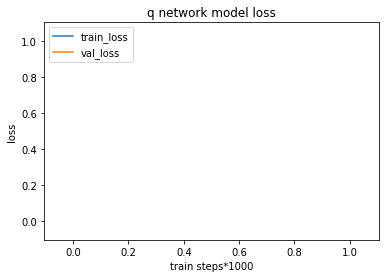

In [34]:
import matplotlib.pyplot as plt
plt.plot(abs_error_list, label = 'train_loss')
plt.plot(val_abserror_list,label = 'val_loss' )
plt.title('q network model loss')
plt.ylabel('loss')
plt.xlabel('train steps*1000')
plt.legend(loc='upper left')
plt.show()